# Gaussian-process regression demo

Here we demonstrate how to use ``inference.gp.GpRegressor`` to perform Gaussian-process regression.

In [1]:
import matplotlib.pyplot as plt
from numpy import array, linspace

Suppose we have the following dataset:

In [2]:
x = array([0.5, 1.0, 1.5, 3.0, 3.5, 4.0, 4.5])
y = array([0.157, -0.150, -0.305, -0.049, 0.366, 0.417, 0.430])

Gaussian-process regression models data using 'covariance functions', also referred to as 'kernels'. The choice of kernel effectively sets certain assumptions about the underlying structure of the data.

For example, the `SquaredExponential` kernel assumes the underlying structure is smooth, and the `WhiteNoise` kernel assumes that our y-data values contain identical independent Gaussian noise. We'll now use these two kernels to show how the choice of kernel can have a strong impact on the regression estimate.

First, we construct a `GpRegressor` using only the `SquaredExponential` kernel:

In [3]:
from inference.gp import GpRegressor, SquaredExponential, WhiteNoise
GP1 = GpRegressor(x, y, kernel=SquaredExponential)

Calling an instance of `GpRegressor` as a function will return the mean and standard deviation of the regression estimate. We can now evaluate the estimate on a new axis to plot the result:

In [4]:
x_fit = linspace(0, 5, 200)
mu1, sigma1 = GP1(x_fit)

Now repeat this process but instead using a combination of the `SquaredExponential` and `WhiteNoise` kernels. We can generate a 'composite' kernel simply by addition as follows:

In [5]:
composite_kernel = SquaredExponential() + WhiteNoise()
GP2 = GpRegressor(x, y, kernel=composite_kernel)
mu2, sigma2 = GP2(x_fit)

Now we have both estimates we can plot them to compare the effect of the different kernels:

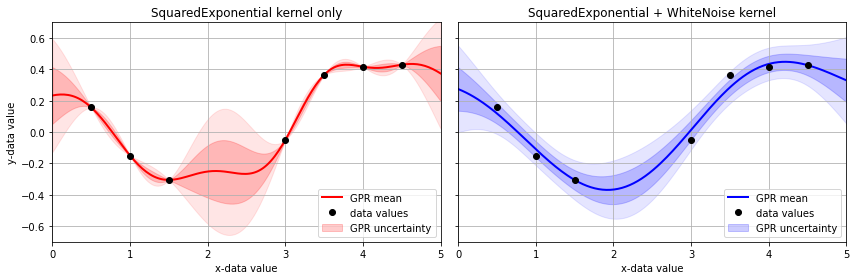

In [6]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.fill_between(x_fit, mu1 - sigma1, mu1 + sigma1, color='red', alpha=0.2, label='GPR uncertainty')
ax1.fill_between(x_fit, mu1 - 2*sigma1, mu1 + 2*sigma1, color='red', alpha=0.1)
ax1.plot(x_fit, mu1, lw=2, c='red', label='GPR mean')
ax1.plot(x, y, 'o', c='black', label='data values')
ax1.set_xlim([0,5])
ax1.set_ylim([-0.7,0.7])
ax1.set_title('SquaredExponential kernel only')
ax1.set_xlabel('x-data value')
ax1.set_ylabel('y-data value')
ax1.legend(loc=4)
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.fill_between(x_fit, mu2 - sigma2, mu2 + sigma2, color='blue', alpha=0.2, label='GPR uncertainty')
ax2.fill_between(x_fit, mu2 - 2*sigma2, mu2 + 2*sigma2, color='blue', alpha=0.1)
ax2.plot(x_fit, mu2, lw=2, c='blue', label='GPR mean')
ax2.plot(x, y, 'o', c='black', label='data values')
ax2.set_xlim([0,5])
ax2.set_ylim([-0.7,0.7])
ax2.set_title('SquaredExponential + WhiteNoise kernel')
ax2.set_xlabel('x-data value')
ax2.set_yticklabels([])
ax2.legend(loc=4)
ax2.grid()

plt.tight_layout()
plt.show()

As the GP using the `SquaredExponential` kernel assumes the data are noiseless, the estimate must pass directly through each data point. Conversely, the GP using a combination of the `SquaredExponential` and `WhiteNoise` kernels is not forced to pass through each point as it is able to assume a level of noise present in the data.

In cases where the uncertainties on the data are known, they can be specified directly using the `y_err` keyword argument of `GpRegressor`. This is particularly useful if there are significant differences in uncertainties across the dataset.

To illustrate this we can manually specify a set of uncertainties for the example dataset to see how this affects the regression estimate:

In [7]:
y_errors = [0.1, 0.01, 0.1, 0.5, 0.1, 0.01, 0.1]
gpr = GpRegressor(x, y, y_err=y_errors, kernel=SquaredExponential)
mu, sig = gpr(x_fit)

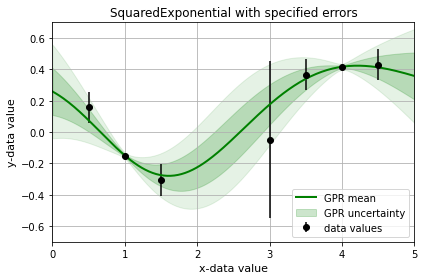

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(x_fit, mu - sig, mu + sig, color='green', alpha=0.2, label='GPR uncertainty')
ax.fill_between(x_fit, mu - 2*sig, mu + 2*sig, color='green', alpha=0.1)
ax.plot(x_fit, mu, lw=2, c='green', label='GPR mean')
ax.errorbar(x, y, yerr=y_errors, marker='o', color='black', ecolor='black', ls='none', label='data values')
ax.set_xlim([0,5])
ax.set_ylim([-0.7,0.7])
ax.set_title('SquaredExponential with specified errors')
ax.set_xlabel('x-data value', fontsize=11)
ax.set_ylabel('y-data value', fontsize=11)
ax.grid()
ax.legend(loc=4)
plt.tight_layout()
plt.show()

As the regression estimate at a collection of points is itself is a multivariate normal distribution, we can construct the full mean vector and covariance matrix which describes that distribution using the `build_posterior` method of `GpRegressor`.

This allows us to draw samples from the distribution:

In [9]:
# get the mean and covariance matrix
means, covar = gpr.build_posterior(x_fit)
# draw samples from the distribution
from numpy.random import multivariate_normal
samples = multivariate_normal(means, covar, 50)

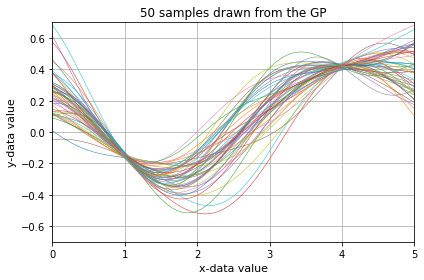

In [10]:
# plot all the samples together
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_fit, samples.T, lw=0.5)
ax.set_xlim([0,5])
ax.set_ylim([-0.7,0.7])
ax.set_title('50 samples drawn from the GP')
ax.set_xlabel('x-data value', fontsize=11)
ax.set_ylabel('y-data value', fontsize=11)
ax.grid()
plt.tight_layout()
plt.show()